In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from src.functions.basic_functions import coordinates_change,globus
from src.functions.grid import land_reference_subunit,construct_grid, estimate_kernel_density_database
from src.functions.weights import weigths_continent, weighted_plants_dataset
from src.functions.plots import unweighted_plot_density, choose_bandwidth,weighted_plants_plot_density, weighted_plot_density

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.basemap import Basemap
import global_land_mask,tqdm, itertools
from global_land_mask import globe
import sklearn
sklearn.set_config(enable_metadata_routing=True)
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV


In [4]:
df_gspt=pd.read_csv("data\clean_data\steel_factories_dataset.csv")

Cross-Validation Bandwiths

In [ ]:
choose_bandwidth('Europe','exponential') # 0.041363636363636366
choose_bandwidth('Europe','gaussian') #0.08172727272727273

Maps

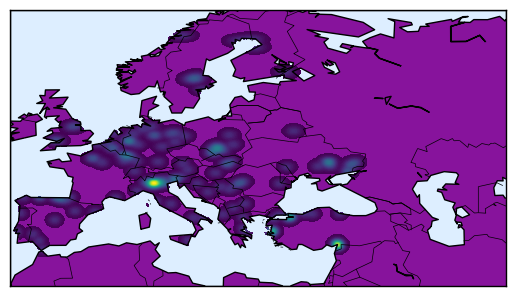

In [182]:
unweighted_plot_density('Europe','gaussian',0.007)

In [ ]:
weighted_plants_plot_density('Europe', 'exponential', 0.007)

In [9]:
weighted_plot_density('North America', 'exponential', 0.007)

In [ ]:
unweighted_plot_density('world','exponential',0.007)

Interpolation

In [6]:
xgrid,ygrid=construct_grid('world',0.1)
land_mask = np.load("data\intermediary_data\land_mask\land_mask_world.npy")
X, Y = np.meshgrid(xgrid, ygrid)
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask] #2151483

In [7]:
world=pd.read_csv("data\intermediary_data\densities\world_all_densities.csv")
work=world.copy()
len(world) #2203395

2203395

In [9]:
work['latitude']=work['latitude'].round(1)
work['longitude']=work['longitude'].round(1)
work=work.rename(columns={'value':'litpop_density'})
work=work[['latitude','longitude','litpop_density','kernel_density']]

In [10]:
work = work.groupby(['latitude', 'longitude']).agg({
    'litpop_density': 'sum',
    'kernel_density': 'sum'
}).reset_index()

In [14]:
len(np.unique(xy,axis=0))==len(xy)

True

In [ ]:
work # 1538131

In [15]:
work=work.sort_values(by=['latitude', 'longitude'])
work['combination']=(work['kernel_density']+work['litpop_density'])/2

In [121]:
z=pd.DataFrame(xy)

In [30]:
if any((xy ==[-67.5, -55.9	 ]).all(axis=1)):
    print(f"The value {[ -90. , -180. ]} is in the data.")
else:
    print(f"The value {[ -90. , -180. ]} is not in the data.")

The value [-90.0, -180.0] is not in the data.


In [24]:
xy

array([[ -90. , -180. ],
       [ -90. , -179.9],
       [ -90. , -179.8],
       ...,
       [  83.6,  -30.3],
       [  83.6,  -30.2],
       [  83.6,  -30.1]])

In [84]:
work

,latitude,longitude,litpop_density,kernel_density,combination
0,-55.9,-67.9,1.447035e-11,3.550150e-27,7.235176e-12
1,-55.9,-67.7,1.167585e-11,3.370116e-27,5.837927e-12
2,-55.9,-67.6,1.635313e-11,3.281638e-27,8.176565e-12
3,-55.9,-67.5,1.204822e-11,3.194244e-27,6.024110e-12
4,-55.9,-67.3,1.793990e-11,2.938966e-27,8.969951e-12
...,...,...,...,...,...
1538126,83.5,-28.3,0.000000e+00,2.364600e-36,1.182300e-36
1538127,83.5,-28.2,0.000000e+00,2.419765e-36,1.209883e-36
1538128,83.6,-32.7,0.000000e+00,6.480858e-37,3.240429e-37
1538129,83.6,-32.6,0.000000e+00,6.630325e-37,3.315163e-37


In [18]:
len(mapping)

2151483

In [19]:
from tqdm import tqdm
mapping = {}
l=[]
for elem in tqdm(xy):
    
    _key = tuple([round(elem[1],1), round(elem[0],1)])
    mapping[_key] = 0
    l.append(_key)
    
for idx, row in tqdm(work.iterrows()):
    key = (round(row.longitude, 1), round(row.latitude, 1))
    if key in mapping:
        mapping[key] = row.combination



  0%|          | 0/2151483 [00:00<?, ?it/s]

100%|██████████| 2151483/2151483 [00:15<00:00, 135991.99it/s]
1538131it [01:06, 23251.71it/s]


In [28]:
[83.6,  -30.1] in xy

False

In [213]:
c=list(mapping.values())
c=np.array(c)
un=np.unique(c)


In [54]:
kde = KernelDensity(bandwidth=0.007, metric='haversine',kernel='exponential')
kde.fit(np.radians(coordinates_change(df_gspt)))
p=np.exp(kde.score_samples(xy))

In [207]:
p.sum()

357443.4545261531

In [214]:
c=c*1000000

In [215]:
c.sum()

987387.5827745766

In [216]:
c.max()

1581.5279484502112

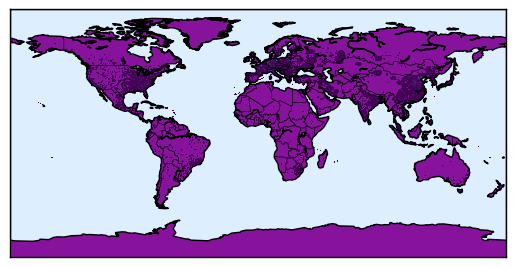

In [217]:
xgrid,ygrid=construct_grid('world',0.1)
X, Y = np.meshgrid(xgrid, ygrid)
land_mask = np.load("data\intermediary_data\land_mask\land_mask_world.npy")
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])
fig, ax = plt.subplots(1, 1)
m=Basemap(projection='cyl', llcrnrlat=Y.min(),urcrnrlat=Y.max(), llcrnrlon=X.min(),
            urcrnrlon=X.max(), resolution='c')
m.drawmapboundary(fill_color='#DDEEFF')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color="#87139c")


# evaluate only on the land: -9999 indicates ocean
Z = np.full(land_mask.shape[0], -9999)
Z[land_mask] = c
Z = Z.reshape(X.shape)

# plot contours of the density
levels = np.linspace(0, Z.max(),100)
ax.contourf(X, Y, Z,levels=levels,cmap='viridis')